In [2]:
import os
data_dir = '/content/drive/MyDrive/cakd5/m9_딥러닝알고리즘구현/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data=f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values

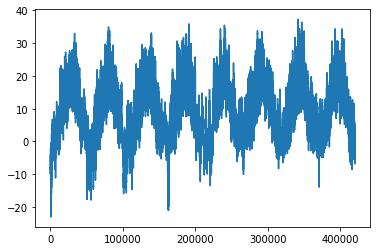

In [4]:
from matplotlib import pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

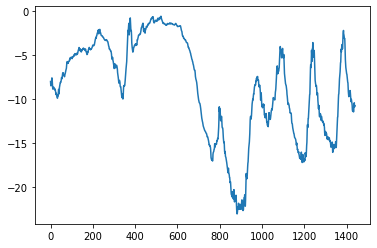

In [ ]:
plt.plot(range(1440),temp[:1440])

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
print(float_data[:,1].mean(),float_data[:,1].std())

0.04211222174014063 0.9515228544484675


이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.
* steps_per_epoch * batch_size = 훈련 샘플 수


In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)
test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_stpes = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 18s 30ms/step - loss: 1.0635 - val_loss: 0.7117
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4197 - val_loss: 0.3447
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2907 - val_loss: 0.3224
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2678 - val_loss: 0.3129
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2534 - val_loss: 0.3162
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2453 - val_loss: 0.3138
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2376 - val_loss: 0.3269
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2329 - val_loss: 0.3178
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2266 - val_loss: 0.3120
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.223

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3360)              0         
                                                                 
 dense (Dense)               (None, 32)                107552    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


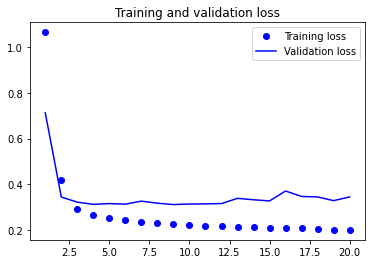

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


결과는 상식적 수준의 기준점인 mae 0.29 보다 좋지 않다. 그 이유는 해당 모델이 핵심 정보를 찾지 못했기 때문이며 즉 시계열 데이터를 펼쳤기 때문에 시간 개념을 잃어버렸다.

[과제] 상기 문제를 해결하기 위하여 순환 시퀀스 처리 모델을 적용하여 데이터 포인트의 시간 순서를 사용하여 과제를 수행(LSTM, GRU)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 18s 29ms/step - loss: 0.3122 - val_loss: 0.2748
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2847 - val_loss: 0.2695
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2767 - val_loss: 0.2670
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2735 - val_loss: 0.2668
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2693 - val_loss: 0.2605
Epoch 6/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2646 - val_loss: 0.2666
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2611 - val_loss: 0.2649
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2569 - val_loss: 0.2671
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2507 - val_loss: 0.2640
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.245

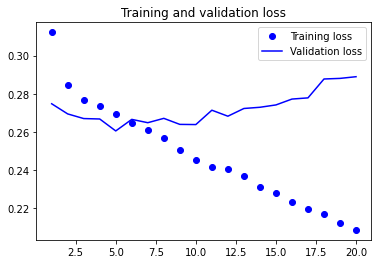

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[과제] 과대적합을 줄이기 위한 방법을 수행
- 순환 dropout
- 스태킹 순환 층
- 양방향 RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,                             # 입력에 대한 드롭아웃 비율
                     recurrent_dropout = 0.2,                   # 순환 상태의 드롭아웃 비율
                     input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                    epochs = 40,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 385s 766ms/step - loss: 0.3282 - val_loss: 0.2865
Epoch 2/40
500/500 [==============================] - 380s 760ms/step - loss: 0.3050 - val_loss: 0.2705
Epoch 3/40
500/500 [==============================] - 385s 769ms/step - loss: 0.3004 - val_loss: 0.2747
Epoch 4/40
500/500 [==============================] - 383s 767ms/step - loss: 0.2944 - val_loss: 0.2675
Epoch 5/40
500/500 [==============================] - 381s 761ms/step - loss: 0.2913 - val_loss: 0.2700
Epoch 6/40
500/500 [==============================] - 377s 754ms/step - loss: 0.2895 - val_loss: 0.2700
Epoch 7/40
500/500 [==============================] - 379s 758ms/step - loss: 0.2839 - val_loss: 0.2731
Epoch 8/40
500/500 [==============================] - 377s 754ms/step - loss: 0.2817 - val_loss: 0.2739
Epoch 9/40
500/500 [==============================] - 378s 756ms/step - loss: 0.2778 - val_loss: 0.2685
Epoch 10/40
500/500 [==============================] - 381s 763m

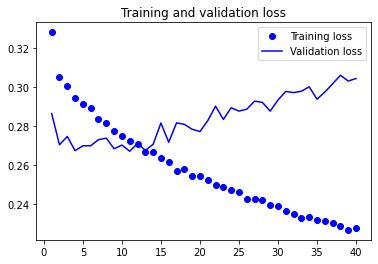

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
# 스태킹 순환 층
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.1,                             # 입력에 대한 드롭아웃 비율
                     recurrent_dropout = 0.5,                   # 순환 상태의 드롭아웃 비율
                     return_sequences = True,
                     input_shape=(None,float_data.shape[-1])))
model.add(layers.GRU(64,activation = 'relu',
                     dropout = 0.1,
                     recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                    epochs = 40,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 685s 1s/step - loss: 0.3197 - val_loss: 0.2863
Epoch 2/40
500/500 [==============================] - 668s 1s/step - loss: 0.3028 - val_loss: 0.2736
Epoch 3/40
500/500 [==============================] - 667s 1s/step - loss: 0.2931 - val_loss: 0.2733
Epoch 4/40
500/500 [==============================] - 667s 1s/step - loss: 0.2869 - val_loss: 0.2793
Epoch 5/40
500/500 [==============================] - 670s 1s/step - loss: 0.2795 - val_loss: 0.2726
Epoch 6/40
500/500 [==============================] - 668s 1s/step - loss: 0.2737 - val_loss: 0.2737
Epoch 7/40
500/500 [==============================] - 670s 1s/step - loss: 0.2688 - val_loss: 0.2757
Epoch 8/40
500/500 [==============================] - 669s 1s/step - loss: 0.2660 - val_loss: 0.2785
Epoch 9/40
500/500 [==============================] - 669s 1s/step - loss: 0.2638 - val_loss: 0.2758
Epoch 10/40
500/500 [==============================] - 671s 1s/step - loss: 0.2585 - val_lo

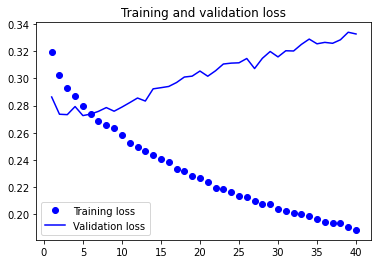

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 양방향 RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32),input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                    epochs = 40,
                    validation_data = val_gen,
                    validation_steps = val_steps)